In [27]:
import os
from numpy import genfromtxt
import numpy as np
from scipy.signal import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import train, test, plot_confusion_matrix, get_gzipped_model_size
import tensorflow as tf
import torch
import keras
from keras.utils import to_categorical
from keras import models, layers
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import StandardScaler
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks


# Data Loader

In [28]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')

# B_size = (label == 0).sum()
#A_size = (label == 1).sum()
B_size = y_train[y_train == 0].shape[0]
A_size = y_train[y_train == 1].shape[0]
print("B_size", B_size)
print("A_size", A_size)

device = (
     "cuda"
     if torch.cuda.is_available()
     else "cpu"
 )
#device = "cpu"
print(f"Using {device} device")

B_size 16005
A_size 339
Using cuda device


# Hyperparameters

In [29]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# TinyFallNet

In [30]:
inputs = keras.Input(shape=(50, 9))
x = layers.Reshape((1, 50, 9))(inputs)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)

x = layers.MaxPooling2D(pool_size=(1, 2))(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)


# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

x = layers.AveragePooling2D(pool_size=(1, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)

TinyFallNet = keras.Model(inputs=inputs, outputs=outputs, name="TinyFallNet")

In [31]:
print(f"Model structure: \n")
TinyFallNet.build(input_shape=(None, 50, 9))
TinyFallNet.summary()

Model structure: 

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 50, 9)             0         ['input_2[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 1, 48, 64)            1792      ['reshape_1[0][0]']           
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 1, 24, 64)            0         ['conv2d_17[0][0]']           
 g2D)                                                                

In [62]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


TinyFallNet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = TinyFallNet.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16344, 2)
y_val.shape:  (4087, 2)
X_train.shape:  (16344, 50, 9)
y_train.shape:  (16344, 2)
Epoch 1/50
256/256 [==============================] - 7s 14ms/step - loss: 0.2361 - accuracy: 0.9534 - val_loss: 0.2496 - val_accuracy: 0.9239 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 3s 12ms/step - loss: 0.3061 - accuracy: 0.9433 - val_loss: 0.2258 - val_accuracy: 0.9403 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 3s 12ms/step - loss: 0.2081 - accuracy: 0.9585 - val_loss: 0.1752 - val_accuracy: 0.9486 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 3s 13ms/step - loss: 0.2031 - accuracy: 0.9569 - val_loss: 0.2161 - val_accuracy: 0.9420 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 3s 12ms/step - loss: 0.1579 - accuracy: 0.9651 - val_loss: 0.1759 - val_accuracy: 0.9423 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 3s 12ms/step - loss: 0.2354 - accurac

In [63]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = TinyFallNet.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)


X_test.shape:  (182, 50, 9)
6/6 - 0s - loss: 0.4348 - accuracy: 0.9176 - 41ms/epoch - 7ms/step
Test loss: [0.43477219343185425, 0.9175823926925659]


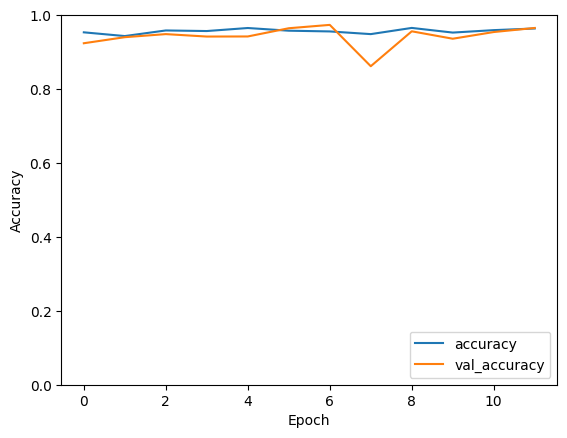

In [64]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

6/6 [==============================] - 0s 4ms/step
[[88  1]
 [14 79]]
Confusion matrix, without normalization
[[88  1]
 [14 79]]
accuracy:  0.9175824175824175
f1_score:  0.9132947976878614


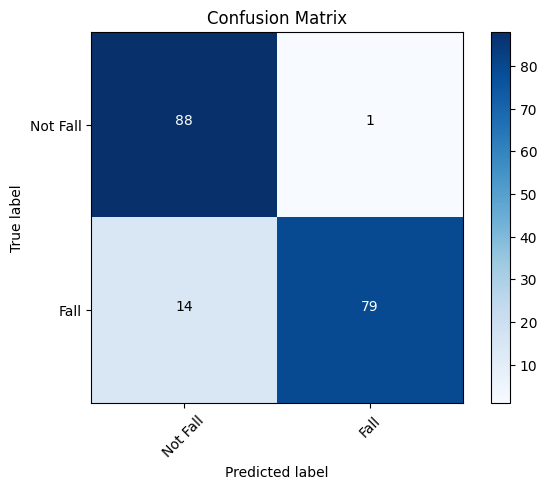

In [79]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(TinyFallNet.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)

In [67]:
TinyFallNet.save('saved_models/TinyFallNet.keras')  # The file needs to end with the .keras extension
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(TinyFallNet)
TinyFallNet_tflite = converter.convert()
# save the model
open("saved_models/TinyFallNet.tflite", "wb").write(TinyFallNet_tflite)

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpj7lii2na\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpj7lii2na\assets


141456

In [68]:
q_TinyFallNet = tfmot.quantization.keras.quantize_model(TinyFallNet)
q_TinyFallNet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_TinyFallNet.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_3 (Quantize  (None, 50, 9)                3         ['input_2[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_1 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer_3[0][0]']    
 rapperV2)                                                                                        
                                                                                        

In [69]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

y_train.shape:  (16344, 2)
y_val.shape:  (4087, 2)


In [70]:
q_history = q_TinyFallNet.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 12s 21ms/step - loss: 0.8214 - accuracy: 0.8569 - val_loss: 0.1692 - val_accuracy: 0.9310 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 18ms/step - loss: 0.3493 - accuracy: 0.9211 - val_loss: 0.1756 - val_accuracy: 0.9401 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 19ms/step - loss: 0.2619 - accuracy: 0.9411 - val_loss: 0.1972 - val_accuracy: 0.9356 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 5s 18ms/step - loss: 0.2466 - accuracy: 0.9468 - val_loss: 0.1960 - val_accuracy: 0.9305 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 5s 18ms/step - loss: 0.1674 - accuracy: 0.9585 - val_loss: 0.1266 - val_accuracy: 0.9606 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 4s 18ms/step - loss: 0.1432 - accuracy: 0.9659 - val_loss: 0.1006 - val_accuracy: 0.9679 - lr: 5.0000e-04
Epoch 7/50
256/256 [===================

In [71]:
q_TinyFallNet.save('saved_models/q_TinyFallNet.keras')  # The file needs to end with the .keras extension


In [72]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(TinyFallNet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_model_quant_int8_qat = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpap80wwsw\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpap80wwsw\assets
g:\python\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [73]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("saved_models/TinyFallNet_quant_int8_qat.tflite", "wb").write(tflite_model_quant_int8_qat)

input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


67576

input:  {'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 50,  9]), 'shape_signature': array([-1, 50,  9]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 73, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
[[88  1]
 [18 75]]
Confusion matrix, without normalization
[[88  1]
 [18 75]]
accuracy:  0.8956043956043956
f1_score:  0.8875739644970414


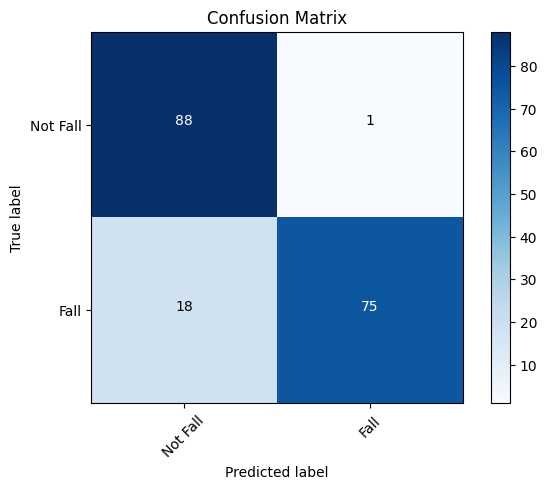

In [78]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= tflite_model_quant_int8_qat)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)



TFLite Model size with 8-bit quantization: 65 KB
TFLite Model size without quantization: 138 KB

Reduction in model size by a factor of 2.093288
accuracy:  0.8956043956043956
Confusion matrix, without normalization
[[88  1]
 [18 75]]


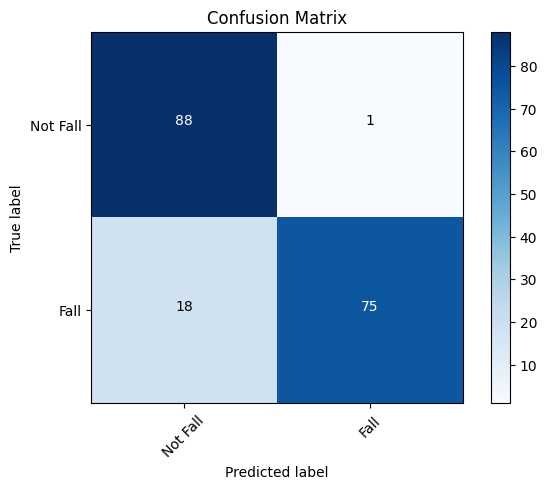

In [75]:
# Show the model size for the 8-bit quantized TFLite model
tflite_in_kb = os.path.getsize('saved_models/TinyFallNet.tflite') / 1024
# ResNet24_tflite tflite_quant_in_kb
tflite_quant_in_kb = os.path.getsize('saved_models/TinyFallNet_quant_int8_qat.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (tflite_in_kb / tflite_quant_in_kb))

accuracy = (predictions == gt).mean()
print('accuracy: ', accuracy)
# compute the confusion matrix
cm = confusion_matrix(gt, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')



In [80]:
print('accuracy of full precision model: ', accuracy_fp)
print('accuracy of quantized model: ', accuracy)

accuracy of full precision model:  0.9175824175824175
accuracy of quantized model:  0.8956043956043956


# Pruning + QAT

In [89]:


# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(TinyFallNet, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 9)             1         ['input_2[0][0]']             
 e_1 (PruneLowMagnitude)                                                                          
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            3522      ['prune_low_magnitude_reshape_
 _17 (PruneLowMagnitude)                                            1[0][0]']                     
                                                                                        

In [90]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 16s 20ms/step - loss: 0.3429 - accuracy: 0.9328 - val_loss: 0.2909 - val_accuracy: 0.9056 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 4s 14ms/step - loss: 0.2498 - accuracy: 0.9465 - val_loss: 0.1401 - val_accuracy: 0.9582 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 4s 14ms/step - loss: 0.2592 - accuracy: 0.9492 - val_loss: 0.1488 - val_accuracy: 0.9528 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 3s 14ms/step - loss: 0.1760 - accuracy: 0.9595 - val_loss: 0.1379 - val_accuracy: 0.9530 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 3s 14ms/step - loss: 0.2127 - accuracy: 0.9563 - val_loss: 0.2339 - val_accuracy: 0.9330 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 4s 15ms/step - loss: 0.1627 - accuracy: 0.9643 - val_loss: 0.1100 - val_accuracy: 0.9704 - lr: 5.0000e-04
Epoch 7/50
256/256 [===================

In [91]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)

Pruned model loss:  1.0858575105667114
Pruned model accuracy:  0.8681318759918213
Full-precision model accuracy:  0.9175824175824175


In [92]:
# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# save the model
pruned_model_unstructured.save('saved_models/TinyFallNet_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

In [93]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = 'saved_models/TinyFallNet_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpby9otlry\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpby9otlry\assets


Saved pruned TFLite model to: g:\MLonMCU\Fall_Detection\saved_models\TinyFallNet_pruned_unstructured.tflite


In [94]:

# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured))
print('Size of the full-precision model: ', get_gzipped_model_size('saved_models/TinyFallNet.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/TinyFallNet_pruned_unstructured.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured)))


Size of the unstructured pruned model:  78129
Size of the full-precision model:  122614
The achieved compression ratio is 1.00x


In [95]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()

Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_5 (Quantize  (None, 50, 9)                3         ['input_2[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_1 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer_5[0][0]']    
 rapperV2)                                                                                        
                                                                                        

In [96]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, pruning_callbacks.UpdatePruningStep()],
            class_weight=class_weight) 


X_train.shape:  (16344, 50, 9)
y_train.shape:  (16344, 2)
64
Epoch 1/50
256/256 [==============================] - 11s 22ms/step - loss: 2.1640 - accuracy: 0.8405 - val_loss: 0.3312 - val_accuracy: 0.8527 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 19ms/step - loss: 0.4048 - accuracy: 0.9066 - val_loss: 0.1625 - val_accuracy: 0.9423 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 18ms/step - loss: 0.2464 - accuracy: 0.9407 - val_loss: 0.1607 - val_accuracy: 0.9469 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 5s 18ms/step - loss: 0.1448 - accuracy: 0.9658 - val_loss: 0.1208 - val_accuracy: 0.9633 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 4s 17ms/step - loss: 0.1349 - accuracy: 0.9700 - val_loss: 0.0947 - val_accuracy: 0.9724 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 4s 17ms/step - loss: 0.1032 - accuracy: 0.9742 - val_loss: 0.0827 - val_accuracy: 0.

In [97]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(X_test, y_test, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', accuracy_fp)



Pruned QAT model loss:  0.6360446810722351
Pruned QAT model accuracy:  0.8846153616905212
Full-precision model accuracy:  0.9175824175824175


In [98]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
open("saved_models/TinyFallNet_pruned_qat.tflite", "wb").write(pruned_qat_tflite_model)

# write TFLite model to a C source (or header) file
#c_model_name = 'pruned_qat_fmnist'

#with open('cfiles/' + c_model_name + '.h', 'w') as file:
#    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))



INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpj6hgari5\assets


INFO:tensorflow:Assets written to: C:\Users\10744\AppData\Local\Temp\tmpj6hgari5\assets
g:\python\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


70216

input:  {'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 50,  9]), 'shape_signature': array([-1, 50,  9]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 75, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
[[85  4]
 [16 77]]
Confusion matrix, without normalization
[[85  4]
 [16 77]]
f1_score:  0.8850574712643678


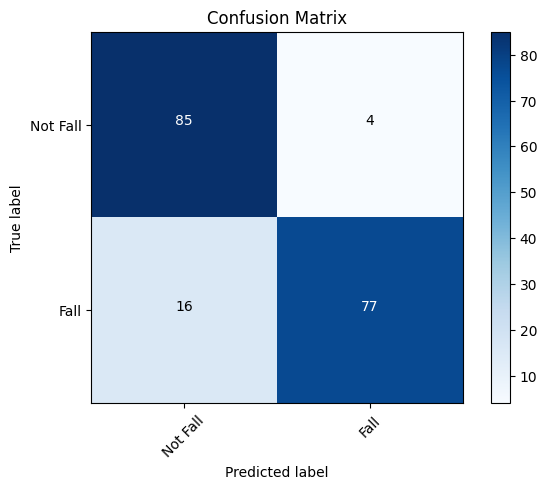

In [100]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= pruned_qat_tflite_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)

In [99]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size('saved_models/TinyFallNet_pruned_qat.tflite'))
print('Size of th QAT model: ', get_gzipped_model_size( 'saved_models/TinyFallNet_quant_int8_qat.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('saved_models/TinyFallNet.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/TinyFallNet.tflite') / get_gzipped_model_size('saved_models/TinyFallNet_pruned_qat.tflite')))

Size of the pruned QAT model:  33839
Size of th QAT model:  42738
Size of the full-precision model:  122614
The achieved compression ratio is 3.62x
